In [22]:
#Convert this notebook to html using pretty-jupyter
#This cell won't show up due to cell-level metadata
# Uncomment the line below and run this cell to produce the HTML report
#!jupyter nbconvert --to html --template pj house_buying.ipynb

C:\Users\lucas\anaconda3\envs\lab\lib\site-packages\pretty_jupyter\constants.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[NbConvertApp] Converting notebook house_buying.ipynb to html
[NbConvertApp] Writing 5879249 bytes to house_buying.html


My goal here is to perform some sensitivity analysis to determine purchasing power as a function of:
- Down payment
- Loan interest rate
- Property tax rate
- PMI Rate
- Home & flood insurance

## Variable Costs (Formulas)
$P$ = purchase price, $D$ = down payment, $r$ = annual note (interest) rate, $L$ = loan amount, $y$ = term (years), $A$ = assessed value, $t$ = effective property tax rate, $H$ = annual homeowner’s insurance premium, $f$ = annual flood insurance premium, $p$ = annual PMI rate (decimal).

$$
\begin{aligned}
L &= P - D \quad &&\text{(loan amount)}\\
i &= \frac{r}{12} \quad &&\text{(monthly interest rate)}\\
n &= 12\,y \quad &&\text{(total number of payments)}\\[6pt]
\text{PI} &= L \cdot \frac{i(1+i)^n}{(1+i)^n - 1} \quad &&\text{(monthly principal \& interest)}\\[6pt]
\text{Taxes} &= \frac{A \cdot t}{12} \quad &&\text{(monthly property taxes)}\\
\text{HOI} &= \frac{H}{12} \quad &&\text{(monthly homeowner's insurance)}\\
\text{PMI} &= \frac{p \cdot L}{12} \quad &&\text{(monthly PMI, if D < 20\%)}\\
\text{Flood} &= \frac{f}{12} \quad &&\text{(monthly flood insurance)}\\[6pt]

\text{Total Monthly} &= \text{PI} + \text{Taxes} + \text{HOI} + \text{PMI} + \text{Flood} + \text{HOA} + \text{Assess}
\end{aligned}
$$

## Monthly Payment Functions
To get started, we'll use some dummy data to fill our prices and rates. Then, we'll build functions to calculate monthly mortgage payments &mdash; both with and without estimated utilities & maintenance costs.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import streamlit as st
import plotly.express as px

# Loan and Property Parameters
purchase_price = 285_000        # Purchase price of the property
down_payment = 30_000           # Down payment amount
note_rate = 0.06                # Annual interest rate on mortgage note
term_years = 30                 # Term of mortgage in years
effective_tax_rate = 0.0091     # Effective property tax rate (0.91%)
annual_premium = 3_120          # Annual insurance premium (I'm seeing avg. costs of $3,069 - $3,732 annually)
pmi_annual_rate = 0.005         # Annual PMI rate (0.5% of loan amount) (I'm seeing avg. rates range from 0.3% - 1.5%)
hoa_monthly = 0                 # Monthly HOA fees 
flood_annual_premium = 400      # Annual flood insurance premium (Seeing costs of $300 - $1,200 annually for FEMA Zone X)

# Additional Monthly Expenses
utilities_monthly = 243         # Monthly utilities estimates for the midwest; $129 (electricity) + $43 (water/sewer) + $71 (gas)
internet_monthly = 50           # Monthly internet estimate - 1Gbps TDS Inc. internet plan (https://tdstelecom.com/shop/packages/best-deals.html)
maintenance_monthly = purchase_price * 0.01 / 12  # Monthly maintenance rate (1% of purchase price)

c:\Users\lucas\anaconda3\envs\lab\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [ ]:

def monthly_payment_with_utilities(purchase_price, down_payment, note_rate, term_years, effective_tax_rate,
                    annual_premium, pmi_annual_rate, hoa_monthly, verbose=False):
    """Calcuates the total estimated monthly payment for a house including utilities and maintenance.

    Args:
        purchase_price (float): The total price of the house.
        down_payment (float): The down payment made on the house.
        note_rate (float): The annual interest rate on the mortgage.
        term_years (integer): The term of the mortgage in years.
        effective_tax_rate (float): The effective property tax rate.
        annual_premium (integer): The annual homeowners insurance premium.
        pmi_annual_rate (float): The annual mortgage insurance premium rate.
        hoa_monthly (integer): The monthly homeowners association fee.
        verbose (bool, optional): If True, prints detailed payment breakdown. Defaults to False.

    Returns:
        float: The total estimated monthly payment.
    """    
    # <1> Principal & Interest (P&I)
    L_base = purchase_price - down_payment                  # Base loan amount
    i = note_rate / 12                                      # Monthly interest rate
    n = term_years * 12                                     # Total number of payments (e.g. 30 years)
    P_and_I = L_base * (i * (1 + i)**n) / ((1 + i)**n - 1)  # Amortizing loan formula (https://www.investopedia.com/terms/a/amortization.asp)

    # <2> Property Taxes
    taxes_monthly = (purchase_price * effective_tax_rate) / 12  # Monthly property taxes; assumes purchase price equals assessed value

    # <3> Homeowners Insurance
    hoi_monthly = annual_premium / 12                           # Estimated monthly homeowners insurance

    # <4> Mortgage Insurance (PMI) - Will be included if down payment < 20% 
    if down_payment < 0.20 * purchase_price:
        pmi_monthly = (L_base * pmi_annual_rate) / 12
    else:
        pmi_monthly = 0

    # <5> Flood Insurance
    flood_monthly = flood_annual_premium / 12  # Estimated monthly flood insurance

    # Total
    total_monthly_payment = P_and_I + taxes_monthly + hoi_monthly + pmi_monthly + hoa_monthly + flood_monthly + utilities_monthly + internet_monthly + maintenance_monthly

    if verbose:
        print(f"Total Estimated Monthly Payment (including utilities & maintenance): ${total_monthly_payment:,.2f}")
        print("=============================================")
        print(f"Principal & Interest (P&I): ${P_and_I:,.2f}")
        print(f"Property Taxes: ${taxes_monthly:,.2f}")
        print(f"Homeowners Insurance: ${hoi_monthly:,.2f}")
        print(f"Mortgage Insurance (PMI): ${pmi_monthly:,.2f}")
        print(f"Flood Insurance: ${flood_monthly:,.2f}")
        print(f"Utilities & Maintenance: ${utilities_monthly + internet_monthly + maintenance_monthly:,.2f}")

    return round(total_monthly_payment, 2)


def monthly_payment(purchase_price, down_payment, note_rate, term_years, effective_tax_rate,
                    annual_premium, pmi_annual_rate, hoa_monthly, verbose=False):
    """Calcuates the total estimated monthly payment for a house; does not include utilities and maintenance.

    Args:
        purchase_price (float): The total price of the house.
        down_payment (float): The down payment made on the house.
        note_rate (float): The annual interest rate on the mortgage.
        term_years (integer): The term of the mortgage in years.
        effective_tax_rate (float): The effective property tax rate.
        annual_premium (integer): The annual homeowners insurance premium.
        pmi_annual_rate (float): The annual mortgage insurance premium rate.
        hoa_monthly (integer): The monthly homeowners association fee.
        verbose (bool, optional): If True, prints detailed payment breakdown. Defaults to False.

    Returns:
        float: The total estimated monthly payment.
    """    
    
    # <1> Principal & Interest (P&I)
    L_base = purchase_price - down_payment                  
    i = note_rate / 12                                      # Monthly interest rate
    n = term_years * 12                                     # Total number of payments (e.g. 30 years)
    P_and_I = L_base * (i * (1 + i)**n) / ((1 + i)**n - 1)  # Monthly P&I payment (Amortizing loan formula)

    # <2> Property Taxes
    taxes_monthly = (purchase_price * effective_tax_rate) / 12  # Monthly property taxes; assumes purchase price equals assessed value

    # <3> Homeowners Insurance
    hoi_monthly = annual_premium / 12                           # Estimated monthly homeowners insurance

    # <4> Mortgage Insurance (PMI) - Will be included if down payment < 20% (https://crosscountrymortgage.com/mortgage/resources/how-to-calculate-pmi/)
    if down_payment < 0.20 * purchase_price:
        pmi_monthly = (L_base * pmi_annual_rate) / 12           # Estimated monthly PMI
    else:
        pmi_monthly = 0

    # <5> Flood Insurance
    flood_monthly = flood_annual_premium / 12                   # Estimated monthly flood insurance

    # Total
    total_monthly_payment = P_and_I + taxes_monthly + hoi_monthly + pmi_monthly + hoa_monthly + flood_monthly

    if verbose:
        print(f"Total Estimated Monthly Payment (w/out utilities & maintenance): ${total_monthly_payment:,.2f}")
        print("=============================================")
        print(f"Principal & Interest (P&I): ${P_and_I:,.2f}")
        print(f"Property Taxes: ${taxes_monthly:,.2f}")
        print(f"Homeowners Insurance: ${hoi_monthly:,.2f}")
        print(f"Mortgage Insurance (PMI): ${pmi_monthly:,.2f}")
        print(f"Flood Insurance: ${flood_monthly:,.2f}")

    return round(total_monthly_payment, 2)

## Testing Functions
Now we can test our functions with some random data - both with and without utilities/maintenance costs.

In [5]:
monthly_payment_with_utilities(purchase_price=purchase_price,
                down_payment=down_payment, note_rate=note_rate, term_years=term_years,
                effective_tax_rate=effective_tax_rate, annual_premium=annual_premium,
                pmi_annual_rate=pmi_annual_rate, hoa_monthly=hoa_monthly, verbose=True)

Total Estimated Monthly Payment (including utilities & maintenance): $2,675.06
Principal & Interest (P&I): $1,528.85
Property Taxes: $216.12
Homeowners Insurance: $260.00
Mortgage Insurance (PMI): $106.25
Flood Insurance: $33.33
Utilities & Maintenance: $530.50


2675.06

In [6]:
monthly_payment(purchase_price=purchase_price,
                down_payment=down_payment, note_rate=note_rate, term_years=term_years,
                effective_tax_rate=effective_tax_rate, annual_premium=annual_premium,
                pmi_annual_rate=pmi_annual_rate, hoa_monthly=hoa_monthly, verbose=True)

Total Estimated Monthly Payment (w/out utilities & maintenance): $2,144.56
Principal & Interest (P&I): $1,528.85
Property Taxes: $216.12
Homeowners Insurance: $260.00
Mortgage Insurance (PMI): $106.25
Flood Insurance: $33.33


2144.56

## Sensitivity Analysis
Now let's try to do some sensitivity analysis with a heatmap visualization, which will show how monthly payments change as interest rates & purchase prices shift.

In [21]:
prices = np.round(np.arange(230_000, 300_001, 7_000), 3)    # 230k to 310k (inclusive) in 7k increments
rates = np.round(np.arange(0.050, 0.0751, 0.005), 3)        # 5.0% to 7.5% (inclusive) in 0.5% increments   

df = pd.DataFrame(index=rates, columns=prices, dtype=float) # Create empty DataFrame to hold results
df.index.name = 'interest_rate'                             # Rows = interest rates
df.columns.name = 'purchase_price'                          # Columns = purchase prices

for r in rates:         # For each interest rate (row)
    for p in prices:    # For each purchase price (column)
        payment = monthly_payment(purchase_price=p, down_payment=down_payment, note_rate=r,         # Calculate monthly payment
                                  term_years=term_years, effective_tax_rate=effective_tax_rate, 
                                  annual_premium=annual_premium, pmi_annual_rate=pmi_annual_rate,
                                  hoa_monthly=hoa_monthly, verbose=False)
        df.loc[r, p] = round(payment, 2)                                                            # Store result in DataFrame

# Create a display-friendly version of the DataFrame
df_display = df.copy()
df_display.index = (df_display.index * 100).map('{:.2f}%'.format)   # Format interest rates as percentages
df_display.index.name = 'Interest Rate'                               # Rename index for display
df_display.columns.name = 'Purchase Price'                          # Rename columns for display
df_display.columns = df_display.columns.map('${:,.0f}'.format)      # Format purchase prices as currency
df_display = df_display.style.format('${:,.2f}')                    # Format all values as currency with 2 decimal places
df_display

Purchase Price,"$230,000","$237,000","$244,000","$251,000","$258,000","$265,000","$272,000","$279,000","$286,000","$293,000","$300,000"
Interest Rate,,,,,,,,,,,
5.00%,"$1,624.73","$1,670.53","$1,716.33","$1,762.13","$1,807.94","$1,853.74","$1,899.54","$1,945.34","$1,991.15","$2,036.95","$2,082.75"
5.50%,"$1,686.66","$1,734.63","$1,782.60","$1,830.57","$1,878.54","$1,926.51","$1,974.48","$2,022.45","$2,070.42","$2,118.39","$2,166.36"
6.00%,"$1,750.18","$1,800.38","$1,850.57","$1,900.76","$1,950.96","$2,001.15","$2,051.35","$2,101.54","$2,151.73","$2,201.93","$2,252.12"
6.50%,"$1,815.22","$1,867.69","$1,920.16","$1,972.63","$2,025.10","$2,077.57","$2,130.04","$2,182.51","$2,234.98","$2,287.45","$2,339.92"
7.00%,"$1,881.69","$1,936.48","$1,991.28","$2,046.08","$2,100.87","$2,155.67","$2,210.47","$2,265.26","$2,320.06","$2,374.85","$2,429.65"
7.50%,"$1,949.51","$2,006.68","$2,063.85","$2,121.02","$2,178.19","$2,235.36","$2,292.53","$2,349.70","$2,406.87","$2,464.04","$2,521.21"


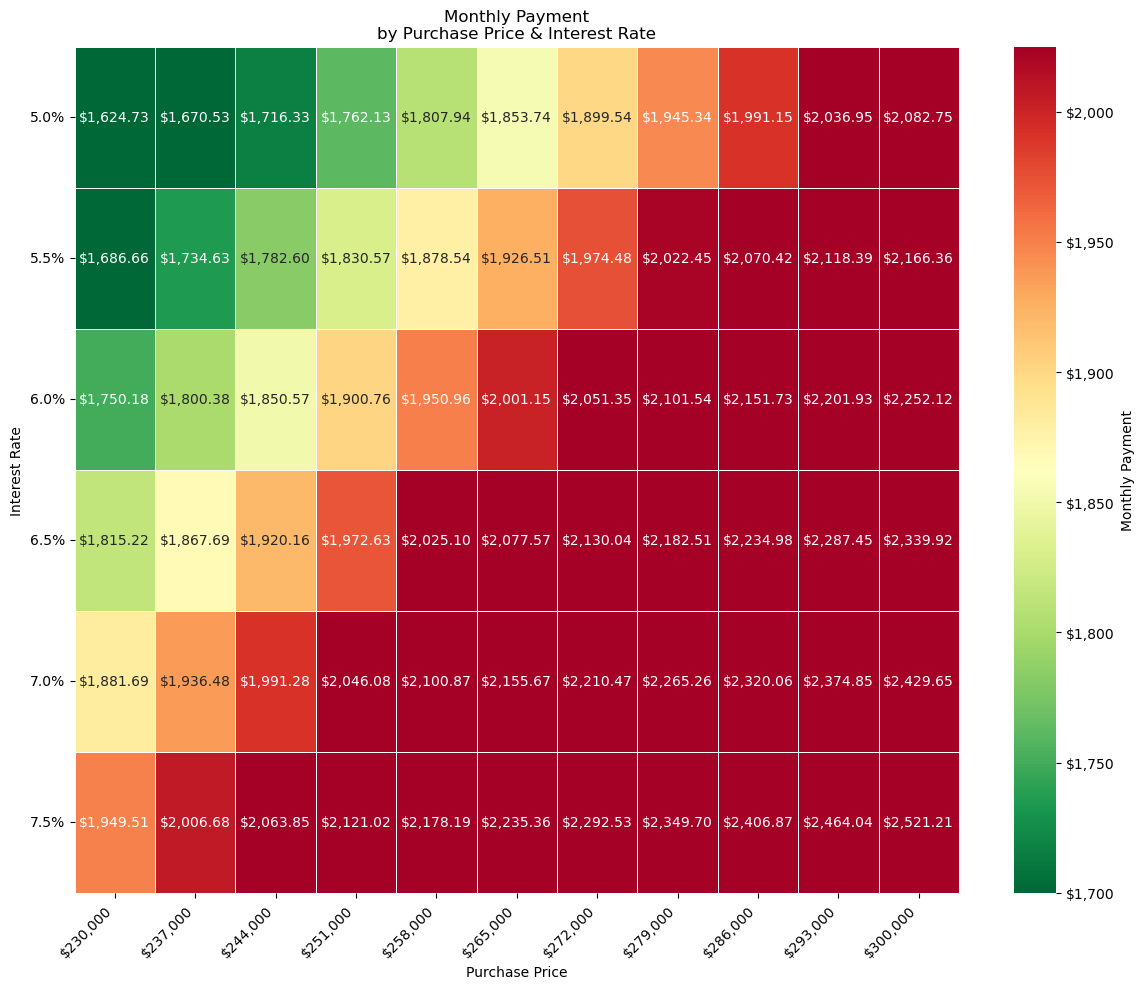

In [ ]:
labels = df.map(lambda v: f"${v:,.2f}")                 # Format monthly payment labels for each heatmap cell

plt.figure(figsize=(12,10))
ax = sns.heatmap(df,                                    # The heatmap is an ax object
                 cmap='RdYlGn_r',                       # Color map (red-yellow-green reversed)
                 linewidths=0.5,                        # Width of lines that will divide each cell
                 cbar_kws={'label':'Monthly Payment'},  # Color bar label
                 annot=labels,                          # Annotate each cell with the formatted monthly payment
                 fmt="",                                # No special string formatting needed since labels are pre-formatted
                 vmin=1_700, vmax=2_025)                # Anchor the color scale between these two values

# Axis labels
ax.set_xlabel('Purchase Price')
ax.set_ylabel('Interest Rate')

# Format tick labels
ax.set_xticklabels([f"${c:,.0f}" for c in df.columns], rotation=45, ha="right") # Format/rotate x-axis labels for better readability
ax.set_yticklabels([f"{r:.1%}" for r in df.index], rotation=0)                  # Format y-axis labels as percentages

cbar = ax.collections[0].colorbar                       # Grab the color bar object from the ax heatmap
cbar.formatter = mtick.StrMethodFormatter("${x:,.0f}")  # Format color bar ticks as currency
cbar.update_ticks()                                     # Update color bar ticks to reflect new formatting

plt.title('Monthly Payment\nby Purchase Price & Interest Rate')
plt.tight_layout()
plt.show()

This report was compiled using [Pretty Jupyter](https://pretty-jupyter.readthedocs.io/en/latest/).